In [1]:
import pyodbc
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from contextlib import contextmanager
from datetime import date
from IPython.display import display, Markdown, HTML

import sys
sys.path.append('../lib/')
from functions import *

# get server credentials from environ.txt
dbconn = os.environ.get('DBCONN', None).strip('"')

In [2]:
#specify date columns
date_cols = [
    "date_antigen_negative",
    "date_exposure_to_disease",
    "date_historic_covid",
    "date_potential_historic_covid",
    "date_probable_covid",
    "date_probable_covid_pos_test",
    "date_probable_covid_sequelae",
    "date_suspected_covid_advice",
    "date_suspected_covid_had_test",
    "date_suspected_covid_isolation",
    "date_suspected_covid_nonspecific",
    "date_suspected_covid",
    "date_covid_unrelated_to_case_status",
    "date_sgss_positive_test",
    "date_died_ons"
]

# import data
df = pd.read_csv(
    filepath_or_buffer = '../output/input.csv',    
    parse_dates = date_cols
)

In [3]:
#when was the study cohort csv file last updated?
cohort_run_date = pd.to_datetime(os.path.getmtime("../output/input.csv"), unit='s')

In [4]:
# get build times from the database
with closing_connection(dbconn) as cnxn:
    DBbuild = pd.read_sql("""select * from LatestBuildTime""", cnxn)
    tablebuild = pd.read_sql(f"""
       select 
           max(BuildDate) as builddate from BuildInfo
       where 
           BuildDesc = 'S1' and 
           BuildDate <= convert(date, '{cohort_run_date.strftime('%Y-%m-%d %H:%M:%S')}')
    """, cnxn)

DB_build_date = pd.to_datetime(DBbuild['DtLatestBuild'].values[0], format='%Y-%m-%d')
S1_build_date = pd.to_datetime(tablebuild['builddate'].values[0], format='%Y-%m-%d')

In [5]:
# this only reflects the data if the study_definition was rerun recently

# state start / end dates
start_date = pd.to_datetime("2020-02-01", format='%Y-%m-%d')
end_date = pd.to_datetime(S1_build_date, format='%Y-%m-%d')
today = date.today()

#derive start/end dates
df["start_date"] = df[date_cols].min().min()
df["end_date"] = df[date_cols].max().max()

# Make a dataframe with consecutive dates
consec_dates = pd.DataFrame(
    index=pd.date_range(start=start_date, end=end_date, freq="D")
)

In [6]:
# choose only date variables
activity_dates = df.filter(items=date_cols)
activity_dates.columns = activity_dates.columns.str.replace("date_", "")

# count code activity per day
codecounts_day = activity_dates.apply(lambda x: eventcountseries(event_dates=x, date_range = consec_dates))

#derive count activity per week
codecounts_week = codecounts_day.resample('W').sum()

#derive total code activity over whole time period
codecounts_total = codecounts_week.sum()

# COVID-19 identification in primary care records from Feb-July 2020: classification of codes for OpenSAFELY studies

## Background

Primary care records offer an opportunity to ascertain cases of COVID-19 which do not necessarily result in hospital admission or death. This could be useful for studying the burden of COVID-19 in the community, risk factors for SARS-CoV-2 infection separately to risk of severe COVID-19, risk factors for mortality and case fatality ratios among those infected, and post-viral effects in people who had COVID-19 that did not require hospitalisation. 

There are over 100 primary care (CTV3) codes with terms related to COVID-19 used by TPP and available for selection in studies performed in the OpenSAFELY platform (https://opensafely.org/).  The majority of these codes have been newly created for use in the current pandemic. The aim of this work was to assign these codes into categories related to the identification of COVID-19 in primary care, and to provide advice for studies using the OpenSAFELY platform that require people to be classified by their COVID-19 case status as defined in primary care records (either as an exposure or as an outcome).

## Methods

An initial list of TPP primary care codes related to COVID-19 was obtained by searching the TPP database for terms containing "COV-2", "Coronavirus", or "COVID". The returned terms were cross-checked against the NHS Digital [COVID-19 SNOMED CT codes](https://hscic.kahootz.com/connect.ti/COVID19_info_sharing/view?objectId=67227941) and CTV3 codes for any missing terms which were added to the list when found.  The resulting list of terms was then reviewed by a team of clinicians, epidemiologists and statisticians in order to identify distinct categories of terms and assign terms into one of these distinct categories. 

An initial analysis of (probable case and suspected case) sub-categories was then performed by plotting the following using OpenSAFELY data from between Feb – July 2020 (1) the frequency of codes entered into TPP software by GPs over time and (2) the proportion of people dying due to (a) COVID-19 and (b) causes other than COVID-19 (using ONS cause of death data) in the 80 days after a record of a (probable case or suspected case) primary care code in TPP.



## Results

A total of 174 terms were identified. These were assigned into the 13 categories/subcategories detailed in the table below. The 13 codelists for classifying COVID-19 are publicly available on OpenSAFELY.org for inspection and re-use [codelists.opensafely.org](https://codelists.opensafely.org/). 



<!--| Category  |  Sub-category (if applicable) |  Description |
|:---|:---|:---|
| Probable case | Clinical code | Clinical diagnosis of COVID-19 made |
|  | Positive test |  Record of positive test result for SARS-CoV-2 (__active infection__) |
|  | Sequelae | Symptom or condition recorded as secondary to SARS-CoV-2 |
| Suspected case | Advice | General advice given about SARS-CoV-2 |
|  | Had test | Record of having had a test for active infection with SARS-CoV-2 |
|  | Isolation code | Self or household-isolation recorded |
|  | Non-sepcific clinical assessment | Clinical assessments plausibly related to COVID-19 |
|  | Suspected codes | "Suspect" mentioned, or previous COVID-19 reported |
| Historic case | - | SARS-CoV-2 antibodies or immunity recorded |
| Potential historic case | - | Has had a test for SARS-CoV-2 antibodies |
| Exposure to disease | - | Record of contact/exposure/procedure |
| Antigen test negative | - | Record of negative test result for SARS-CoV-2 |
| COVID-19 related contact but case status not specified | - | Healthcare contact related to COVID-19 but not case status |
-->

In [7]:
tableindex = [
    "probable_covid",
    "probable_covid_pos_test",
    "probable_covid_sequelae",
    "suspected_covid_advice",
    "suspected_covid_had_test",
    "suspected_covid_isolation",
    "suspected_covid_nonspecific",
    "suspected_covid",
    "historic_covid",
    "potential_historic_covid",
    "exposure_to_disease",
    "antigen_negative",
    "covid_unrelated_to_case_status"
]

tabledata = {
    'Category':[
        'Probable case',
        '',
        '',
        'Suspected case',
        '',
        '',
        '',
        '',
        'Historic case',
        'Potential historic case',
        'Exposure to disease',
        'Antigen test negative',
        'COVID-19 related but case status not specified',        
    ],
    'Sub-category':[
        'Clinical code',
        'Positive test',
        'Sequalae',
        'Advice',
        'Had test',
        'Isolation code',
        'Non-specific clinical assessment',
        'Suspected codes',
        '-',
        '-',
        '-',
        '-',
        '-',
    ],
    'Codelist':[
        'Probable case: clinical code',
        'Probable case: positive test',
        'Probable case: sequelae',
        'Suspected case: advice',
        'Suspected case: had test',
        'Suspected case: isolation code',
        'Suspected case: non-specific clinical assessment',
        'Suspected case: suspected codes',
        'Historic case',
        'Potential historic case',
        'Exposure to disease',
        'Antigen test negative',
        'COVID-19 related but case status not specified',   
    ],
    'Description':[
        'Clinical diagnosis of COVID-19 made',
        'Record of positive test result for SARS-CoV-2 (active infection)',
        'Symptom or condition recorded as secondary to SARS-CoV-2',
        'General advice given about SARS-CoV-2',
        'Record of having had a test for active infection with SARS-CoV-2',
        'Self- or household-isolation recorded',
        'Clinical assessments plausibly related to COVID-19',
        '"Suspect" mentioned, or previous COVID-19 reported',
        'SARS-CoV-2 antibodies or immunity recorded',
        'Has had a test for SARS-CoV-2 antibodies',
        'Record of contact/exposure/procedure',
        'Record of negative test result for SARS-CoV-2',
        'Healthcare contact related to COVID-19 but not case status',      
    ],
    'link':[
        "https://codelists.opensafely.org/codelist/opensafely/covid-identification-in-primary-care-probable-covid-clinical-code/2020-07-16/",
        "https://codelists.opensafely.org/codelist/opensafely/covid-identification-in-primary-care-probable-covid-positive-test/2020-07-16/",
        "https://codelists.opensafely.org/codelist/opensafely/covid-identification-in-primary-care-probable-covid-sequelae/2020-07-16/",
        "https://codelists.opensafely.org/codelist/opensafely/covid-identification-in-primary-care-suspected-covid-advice/2020-07-16/",
        "https://codelists.opensafely.org/codelist/opensafely/covid-identification-in-primary-care-suspected-covid-had-test/2020-07-16/",
        "https://codelists.opensafely.org/codelist/opensafely/covid-identification-in-primary-care-suspected-covid-isolation-code/2020-07-16/",
        "https://codelists.opensafely.org/codelist/opensafely/covid-identification-in-primary-care-suspected-covid-nonspecific-clinical-assessment/2020-07-16/",
        "https://codelists.opensafely.org/codelist/opensafely/covid-identification-in-primary-care-suspected-codes-suspected-codes/2020-07-16/",
        "https://codelists.opensafely.org/codelist/opensafely/covid-identification-in-primary-care-historic-case/2020-06-23/",
        "https://codelists.opensafely.org/codelist/opensafely/covid-identification-in-primary-care-potential-historic-case/2020-06-23/",
        "https://codelists.opensafely.org/codelist/opensafely/covid-identification-in-primary-care-exposure-to-disease/2020-06-23/",
        "https://codelists.opensafely.org/codelist/opensafely/covid-identification-in-primary-care-antigen-test-negative/2020-06-24/",
        "https://codelists.opensafely.org/codelist/opensafely/covid-identification-in-primary-care-unrelated-to-case-status/2020-06-23/",
    ]
}

tabledata = pd.DataFrame(tabledata, index=tableindex)
tabledata['Codelist']="<a href='"+tabledata['link']+"' target='_blank'>"+tabledata['Codelist']+"</a>"

codecounts_total.name = "Count"

tabledata = tabledata.merge(codecounts_total, left_index=True, right_index=True)

# easy but not ideal output
#display(HTML(tabledata.to_html(index=False, justify='left')))

# use styling instead - https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html
styles = [dict(selector="th", props=[("text-align", "left")])]

# with hyperlinks
tabledata[["Codelist", "Description", "Count"]].style.set_properties(subset=["Codelist","Description"], **{'text-align':'left', 'index':False}).set_table_styles(styles).hide_index()

#without hyperlinks
#tabledata[["Category", "Sub-category" "Description", "Count"]].style.set_properties(subset=["Category","Sub-category","Description"], **{'text-align':'left', 'index':False}).set_table_styles(styles).hide_index()

Codelist,Description,Count
Probable case: clinical code,Clinical diagnosis of COVID-19 made,38625
Probable case: positive test,Record of positive test result for SARS-CoV-2 (active infection),142228
Probable case: sequelae,Symptom or condition recorded as secondary to SARS-CoV-2,2752
Suspected case: advice,General advice given about SARS-CoV-2,384271
Suspected case: had test,Record of having had a test for active infection with SARS-CoV-2,150723
Suspected case: isolation code,Self- or household-isolation recorded,125549
Suspected case: non-specific clinical assessment,Clinical assessments plausibly related to COVID-19,13
Suspected case: suspected codes,"""Suspect"" mentioned, or previous COVID-19 reported",588530
Historic case,SARS-CoV-2 antibodies or immunity recorded,5152
Potential historic case,Has had a test for SARS-CoV-2 antibodies,30014


In [8]:
display(Markdown(f"""
"Probable" and "suspected" sub-categories are explored further here. 
Plots of frequency of codes (Figure 1) showed that while the frequency of use of "probable case: clinical code" (n={codecounts_total["probable_covid"]}) was similar to "probable case: positive test" (n={codecounts_total["probable_covid_pos_test"]}) over time, 
"probable case: sequelae" codes were used much less frequently over the whole time period (n={codecounts_total["probable_covid_sequelae"]}). 
Suspected case sub-categories were used much more frequently than "probable case: positive test" - suspected case: "advice given" (n={codecounts_total["suspected_covid_advice"]}),
"isolation code" (n={codecounts_total["suspected_covid_isolation"]}) and "suspected codes" (n={codecounts_total["suspected_covid"]}) (Figure 1). 
Plots of causes of death after each code showed marked differences in the proportion of death due to COVID-19 compared to deaths due to other causes for all probable case sub-categories; 
in contrast, COVID-19 deaths were not substantially higher than non-COVID deaths following codes in the "suspected" COVID-19 case sub-categories (Figure 2).
"""))


"Probable" and "suspected" sub-categories are explored further here. 
Plots of frequency of codes (Figure 1) showed that while the frequency of use of "probable case: clinical code" (n=38625) was similar to "probable case: positive test" (n=142228) over time, 
"probable case: sequelae" codes were used much less frequently over the whole time period (n=2752). 
Suspected case sub-categories were used much more frequently than "probable case: positive test" - suspected case: "advice given" (n=384271),
"isolation code" (n=125549) and "suspected codes" (n=588530) (Figure 1). 
Plots of causes of death after each code showed marked differences in the proportion of death due to COVID-19 compared to deaths due to other causes for all probable case sub-categories; 
in contrast, COVID-19 deaths were not substantially higher than non-COVID deaths following codes in the "suspected" COVID-19 case sub-categories (Figure 2).


## Conclusion

A high level of COVID-19 related mortality in people identified as "probable cases" is consistent with these codes identifying true COVID-19 cases with high specificity. "Suspected case" codes were more widely used but a much lower level of subsequent COVID-19 related mortality suggesting that these codes may have low specificity for COVID-19 and should be used with care.  Further work will include assessing the impact of the introduction of pillar 2 test results on utilisation of these codes, investigating code sensitivity, and understanding how individual patient characteristics relate to the varying probability of being tested.


## Figure 1: Frequency of primary care code use over time.

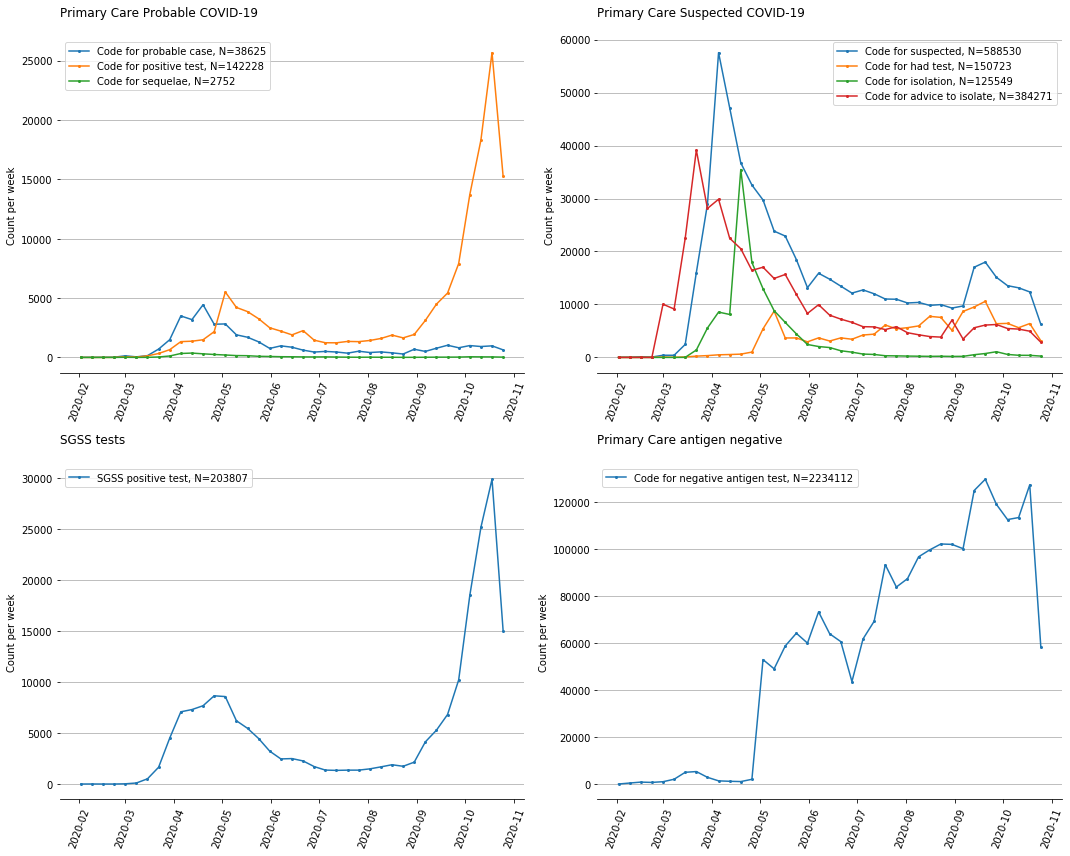

In [38]:

def plotstyle(axesrow, axescol, title):
    axs[axesrow,axescol].set_ylabel('Count per week')
    axs[axesrow,axescol].xaxis.set_tick_params(labelrotation=70)
    #axs[0,0].set_ylim(bottom=0) # might remove this in future depending on count fluctuation
    axs[axesrow,axescol].grid(axis='y')
    axs[axesrow,axescol].legend()
    axs[axesrow,axescol].set_title(title, loc='left', y=1)
    axs[axesrow,axescol].tick_params(labelbottom=True)
    axs[axesrow,axescol].spines["left"].set_visible(False)
    axs[axesrow,axescol].spines["right"].set_visible(False)
    axs[axesrow,axescol].spines["top"].set_visible(False)
    

fig, axs = plt.subplots(2, 2, figsize=(15,12), sharey=False,  sharex=True)

axs[0,0].plot(codecounts_week.index, codecounts_week["probable_covid"], marker='o', markersize=2, label=f"""Code for probable case, N={codecounts_total["probable_covid"]}""")
axs[0,0].plot(codecounts_week.index, codecounts_week["probable_covid_pos_test"],  marker='o', markersize=2, label=f"""Code for positive test, N={codecounts_total["probable_covid_pos_test"]}""")
axs[0,0].plot(codecounts_week.index, codecounts_week["probable_covid_sequelae"], marker='o', markersize=2, label=f"""Code for sequelae, N={codecounts_total["probable_covid_sequelae"]}""")
plotstyle(0,0, "Primary Care Probable COVID-19\n");
    
axs[0,1].plot(codecounts_week.index, codecounts_week["suspected_covid"], marker='o', markersize=2, label=f"""Code for suspected, N={codecounts_total["suspected_covid"]}""")
axs[0,1].plot(codecounts_week.index, codecounts_week["suspected_covid_had_test"], marker='o', markersize=2, label=f"""Code for had test, N={codecounts_total["suspected_covid_had_test"]}""")
axs[0,1].plot(codecounts_week.index, codecounts_week["suspected_covid_isolation"], marker='o', markersize=2, label=f"""Code for isolation, N={codecounts_total["suspected_covid_isolation"]}""")
axs[0,1].plot(codecounts_week.index, codecounts_week["suspected_covid_advice"], marker='o', markersize=2, label=f"""Code for advice to isolate, N={codecounts_total["suspected_covid_advice"]}""")
plotstyle(0,1, "Primary Care Suspected COVID-19\n");

axs[1,0].plot(codecounts_week.index, codecounts_week["sgss_positive_test"], marker='o', markersize=2, label=f"""SGSS positive test, N={codecounts_total["sgss_positive_test"]}""")
plotstyle(1,0, "SGSS tests\n");

axs[1,1].plot(codecounts_week.index, codecounts_week["antigen_negative"], marker='o', markersize=2, label=f"""Code for negative antigen test, N={codecounts_total["antigen_negative"]}""")
axs[1,1].legend()
plotstyle(1,1, "Primary Care antigen negative\n");

#axs[1,1].remove()
#axs[1,2].remove()

plt.tight_layout()
#fig.suptitle("test title",fontsize=16, y=1)
plt.show()

## Figure 2: Comparison of mortality from COVID-19 or other causes in the 80 days following a positive test

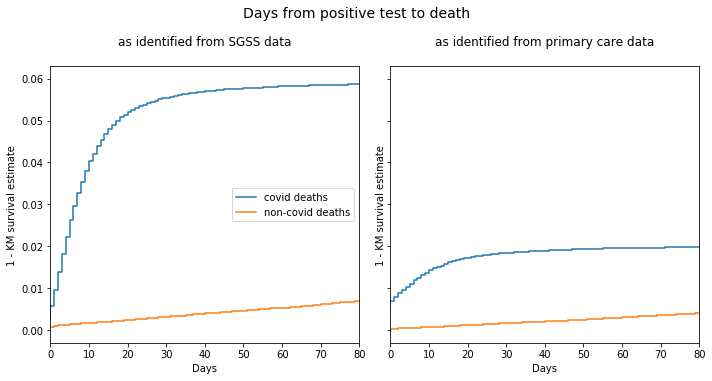

In [27]:
# derive time-to-event censoring info

# death date or last date of follow up
df['date_event'] = np.where(df['date_died_ons']<=df['end_date'], df['date_died_ons'], df['end_date'])

# censoring indiators
df['indicator_death'] = np.where((df['date_died_ons']<=df['end_date']) & (df['died_ons']==1), 1, 0)
df['indicator_death_covid'] = np.where((df['date_died_ons']<=df['end_date'])  & (df['died_ons_covid']==1), 1, 0)
df['indicator_death_noncovid'] = np.where((df['date_died_ons']<=df['end_date']) & (df['died_ons_noncovid']==1), 1, 0)

# censor death category if end date exceeds last date
df['death_category'] = np.where(df['date_died_ons']<=df['end_date'], df['death_category'], "alive")

# derive time-to-death from positive test date
df['pvetestSGSS_to_death'] = (df['date_event'] - df['date_sgss_positive_test']).astype('timedelta64[D]')
df['pvetestPC_to_death'] = (df['date_event'] - df['date_probable_covid_pos_test']).astype('timedelta64[D]')

## positive test as indicated in SGSS or in primary care
df_pvetestSGSS = df[~np.isnan(df['date_sgss_positive_test'])]
df_pvetestPC = df[~np.isnan(df['date_probable_covid_pos_test'])]


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5), sharey=True)

# SGSS pos test to death
kmdata = KMestimate(df_pvetestSGSS['pvetestSGSS_to_death'], df_pvetestSGSS['indicator_death'])
kmdata_covid = KMestimate(df_pvetestSGSS['pvetestSGSS_to_death'], df_pvetestSGSS['indicator_death_covid'])
kmdata_noncovid = KMestimate(df_pvetestSGSS['pvetestSGSS_to_death'], df_pvetestSGSS['indicator_death_noncovid'])

axes[0].step(kmdata_covid['times'], 1-kmdata_covid['kmestimate'], label='covid deaths') 
axes[0].step(kmdata_noncovid['times'], 1-kmdata_noncovid['kmestimate'], label = 'non-covid deaths')
axes[0].set_xlabel('Days')
axes[0].set_ylabel('1 - KM survival estimate')
axes[0].set_title("as identified from SGSS data\n")
axes[0].legend()
axes[0].set_xlim(0, 80)

# PC pos test to death
kmdata = KMestimate(df_pvetestPC['pvetestPC_to_death'], df_pvetestPC['indicator_death'])
kmdata_covid = KMestimate(df_pvetestPC['pvetestPC_to_death'], df_pvetestPC['indicator_death_covid'])
kmdata_noncovid = KMestimate(df_pvetestPC['pvetestPC_to_death'], df_pvetestPC['indicator_death_noncovid'])

axes[1].step(kmdata_covid['times'], 1-kmdata_covid['kmestimate'], label='covid deaths') 
axes[1].step(kmdata_noncovid['times'], 1-kmdata_noncovid['kmestimate'], label = 'non-covid deaths')
axes[1].set_xlabel('Days')
axes[1].set_ylabel('1 - KM survival estimate')
axes[1].set_title("as identified from primary care data\n")
axes[1].set_xlim(0, 80)

fig.suptitle("Days from positive test to death", y=1.05, fontsize=14)
fig.tight_layout()

In [11]:
display(Markdown(f"""
## Technical details

This notebook was run on {today.strftime('%Y-%m-%d')}, based on SystmOne data as at {S1_build_date.strftime('%Y-%m-%d')}. 

Codelist activity is reported from {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}. If a clinical code appears in the primary care record on multiple dates, the earliest date is used. 

This dataset was created using the study definition `/analysis/study_definintion.py`. 

If there are multiple events per patient within the extraction period, the earliest event date is extracted.

Only patients registered at their practice continuously for one year up to 1 Feb 2020 are included.

Click the button below to show the underlying python code that this notebook is based on.
"""))


## Technical details

This notebook was run on 2020-11-06, based on SystmOne data as at 2020-10-23. 

Codelist activity is reported from 2020-02-01 to 2020-10-23. If a clinical code appears in the primary care record on multiple dates, the earliest date is used. 

This dataset was created using the study definition `/analysis/study_definintion.py`. 

If there are multiple events per patient within the extraction period, the earliest event date is extracted.

Only patients registered at their practice continuously for one year up to 1 Feb 2020 are included.

Click the button below to show the underlying python code that this notebook is based on.


### Notes on OpenSAFELY

OpenSAFELY is a data analytics platform built by a mixed team of software developers, clinicians, and epidemiologists from the Oxford DataLab, London School of Hygiene and Tropical Medicine Electronic Health Record research group, health software company TPP and NHS England. It represents a fundamentally different way of conducting electronic health record (EHR) research: instead of sending EHR data to a third party for analysis, we've developed a system for conducting analyses within the secure environment where the data is already stored, so that the electronic health record data never leaves the NHS ecosystem. 

Currently, OpenSAFELY uses the electronic health records of all patients registered at a GP practice using the SystmOne clinical information system run by TPP, covering around 22 million people. Additional data for these patients covering COVID-related tests, hospital admissions, ITU admissions, and registered deaths are also securely imported to the platform. 

For more information, visit https://opensafely.org